<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 20px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 1;">
      <img src="../../utils/logo-motion15.gif" width="100px" style="border: 0; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; font-weight: bold; text-align: left; font-size: 38px;">
      Cross-Validation using Purged K-fold
    </h1>
  </div>  
</div>

This notebook demonstrates how to use the `PurgedKFold` cross-validator from the `RiskLabAI` library to run a robust financial backtest. 

Standard `KFold` cross-validation fails in finance because:
1.  **Leakage:** The training set can contain information that overlaps with the test set (e.g., from overlapping triple-barrier labels).
2.  **Embargo:** Information from the test set can 'leak' back into the training set that follows it.

`PurgedKFold` (De Prado, Chapter 7) solves this by:
1.  **Purging:** Removing any training samples whose labels are concurrent with test set samples.
2.  **Embargoing:** Removing training samples that immediately *follow* the test set to prevent look-ahead bias.

We will:
1.  Load data and generate features/labels.
2.  Define the `event_times` (`t1`) needed for purging.
3.  Instantiate and visualize `PurgedKFold`.
4.  Run a full backtest loop with a `RandomForestClassifier`.

## 0. Setup and Imports

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Third-party for data and modeling
import yfinance as yf
import ta
from ta.utils import dropna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# RiskLabAI Imports
from RiskLabAI.backtest.validation import PurgedKFold
import RiskLabAI.utils.publication_plots as pub_plots

# Setup plotting and configuration
pub_plots.setup_publication_style()
warnings.filterwarnings('ignore')

Matplotlib style updated for publication.


## 1. Load Data & Generate Signals

We will load 'SPY' data and generate some simple features and labels. For this example, we will assume a simple fixed-time horizon label (e.g., 20 days), so our `event_times` (`t1`) will be 20 days after the observation.

In [2]:
import yfinance as yf
import pandas as pd
import ta
from ta.utils import dropna

# --- 1. Load Data ---
ticker_symbol = "SPY"
start_date = "2010-01-01"
end_date = "2025-01-01"

data = yf.Ticker(ticker_symbol).history(
    start=start_date, 
    end=end_date, 
    auto_adjust=True
)

data.index = data.index.tz_localize(None)

# --- 2. Generate Features (X) ---
X = pd.DataFrame(index=data.index)
X['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
X['roc'] = ta.momentum.ROCIndicator(data['Close'], window=10).roc()

# --- 3. Generate Labels (y) ---
look_forward = 20
y = data['Close'].pct_change(look_forward).shift(-look_forward)
y = pd.Series((y > 0).astype(int), name='label')

# --- 4. Define Event Times (t1) ---
# The label's 'end time' is 20 days after the observation.
event_times = pd.Series(y.index, index=y.index).apply(lambda x: x + pd.DateOffset(days=look_forward))

# --- 5. Align Data ---
# Combine all data and drop NaNs to ensure X, y, and t1 are aligned
all_data = pd.concat([X, y, event_times.rename('t1')], axis=1).dropna()

X = all_data.drop(columns=['label', 't1'])
y = all_data['label']
event_times = all_data['t1']

print(f"--- SPY (ETF) Data Loaded (TZ-Naive) ---")
print(f"Aligned data shapes: X={X.shape}, y={y.shape}, t1={event_times.shape}")
print(X.head())

--- SPY (ETF) Data Loaded (TZ-Naive) ---
Aligned data shapes: X=(3761, 2), y=(3761,), t1=(3761,)
                  rsi       roc
Date                           
2010-01-22  27.005482 -4.361185
2010-01-25  31.251353 -4.189587
2010-01-26  29.722131 -4.724164
2010-01-27  33.673202 -3.369715
2010-01-28  29.365153 -5.278291


## 2. Visualizing Purged K-Fold Splits

Before we run the backtest, let's visualize how `PurgedKFold` creates its splits. We'll use a `n_splits=10`.

Notice how the **blue (train)** bar is 'purged' (stops early) before the **orange (test)** bar begins, and an 'embargo' (a gap) is left after the test bar ends. This prevents any information leakage.

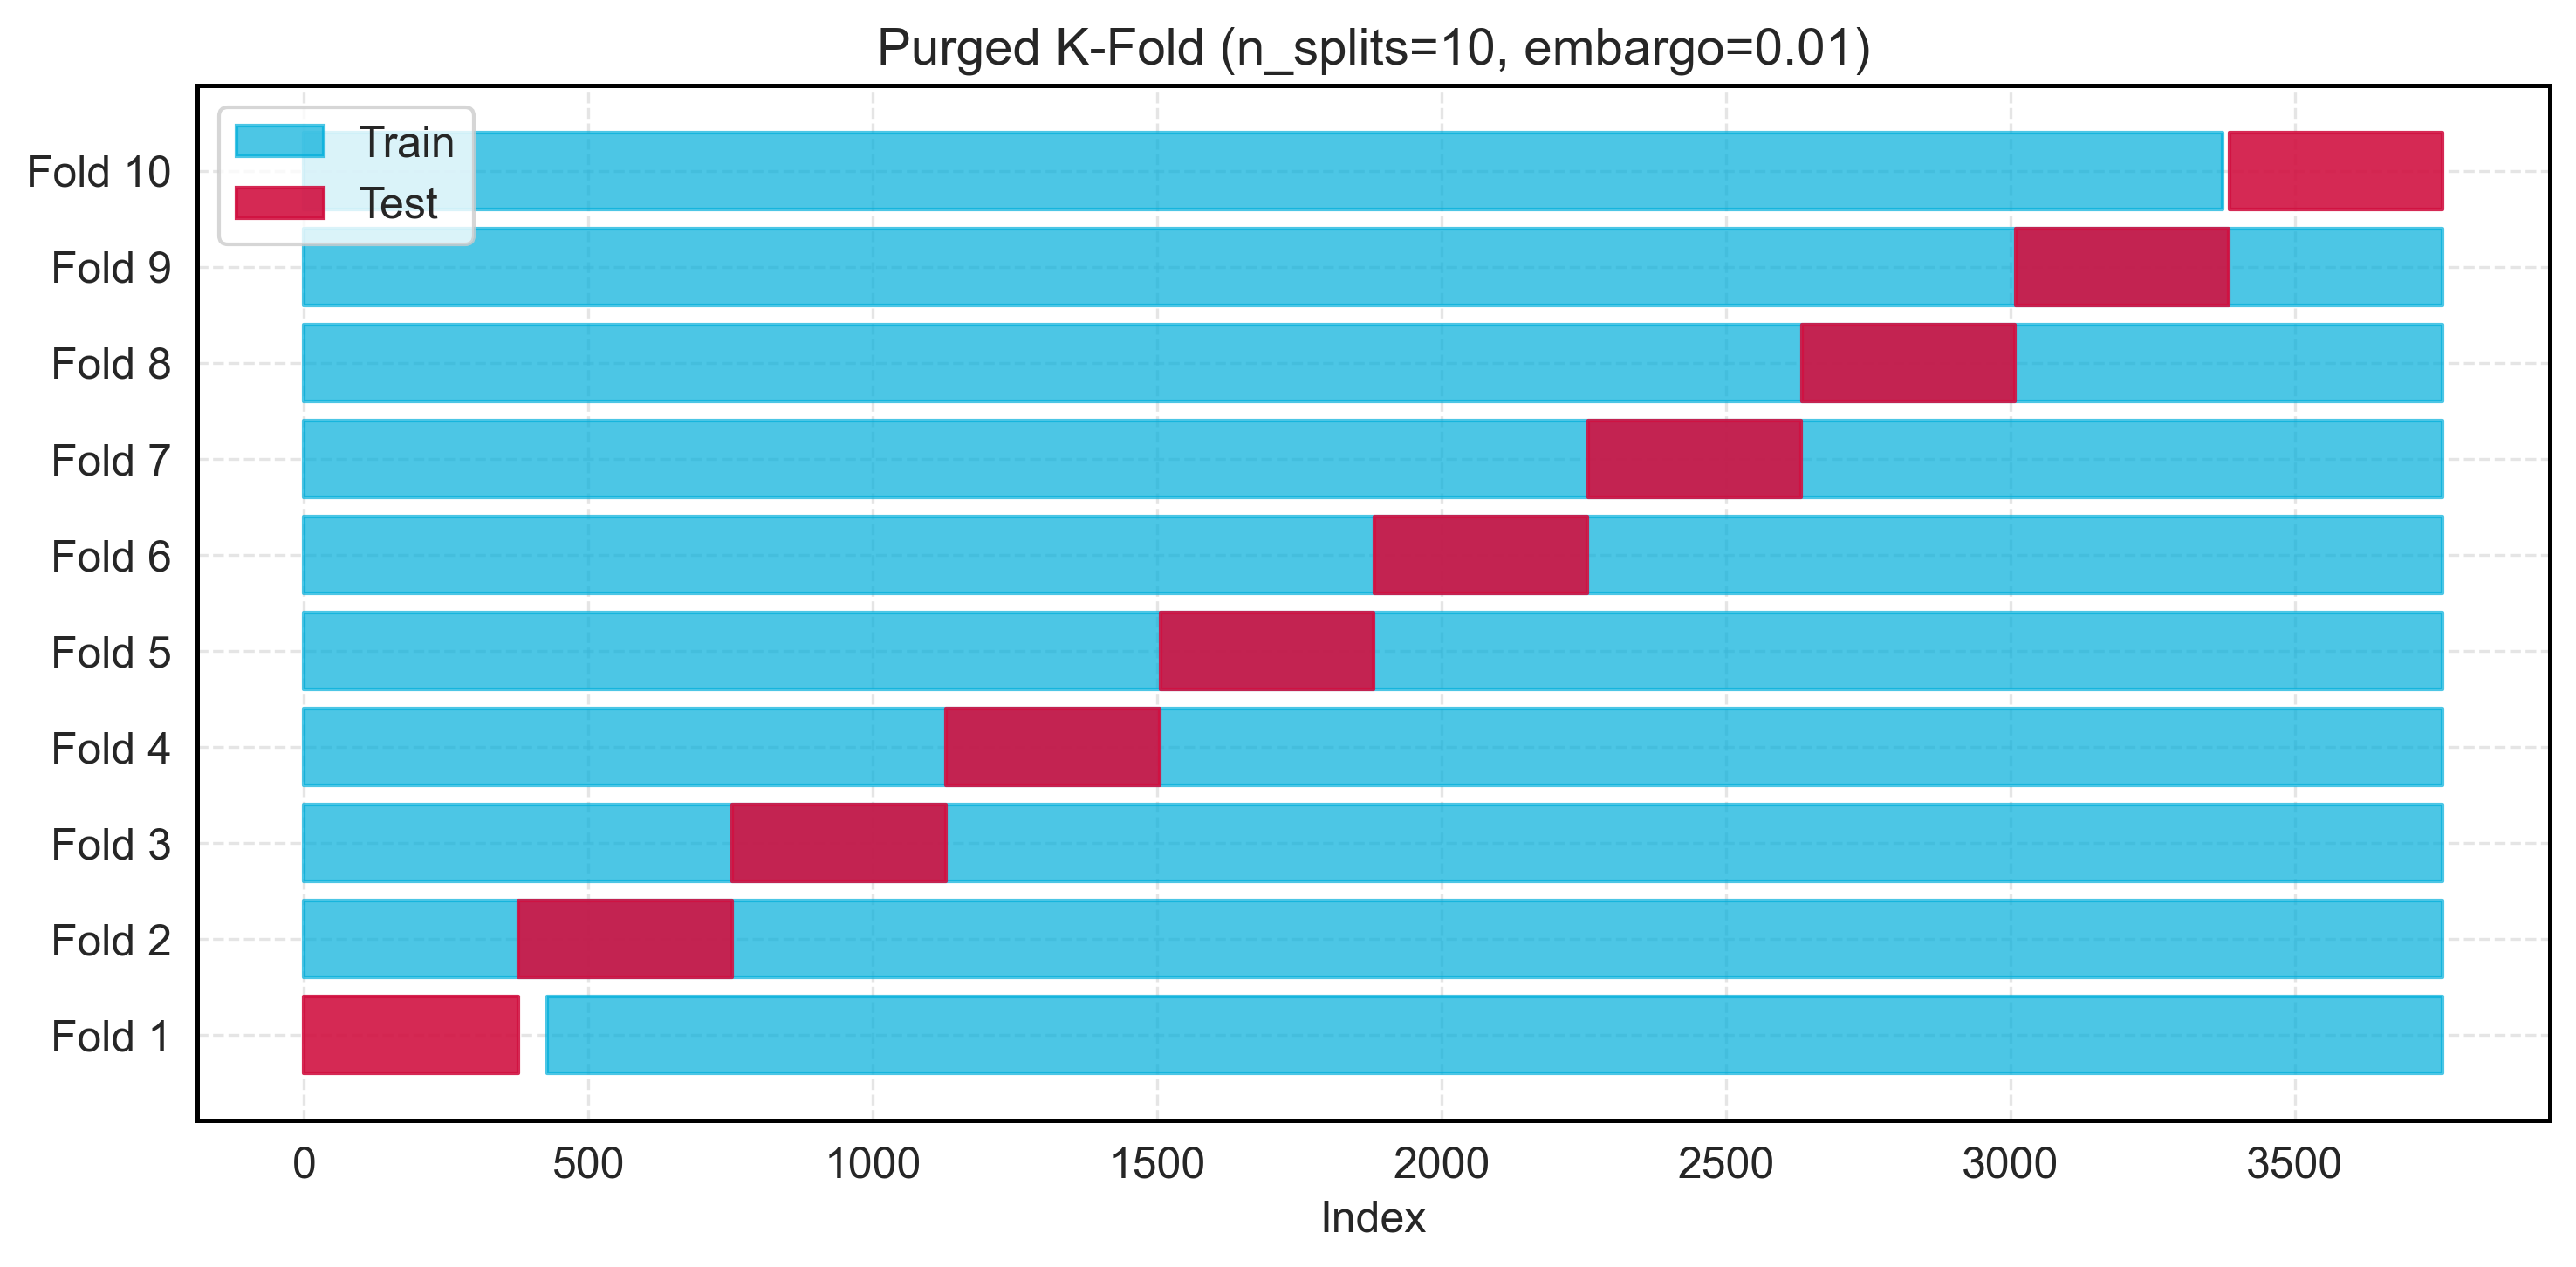

In [3]:
n_splits = 10
embargo_pct = 0.01 # 1% embargo

cv = PurgedKFold(
    n_splits=n_splits,
    times=event_times,  # <-- ADD THIS
    embargo=embargo_pct   # <-- RENAME THIS
)

# --- Plotting the CV splits --- 
fig, ax = plt.subplots(figsize=(10, 5))
fold_indices = range(n_splits)


for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    # Plot training indices
    ax.fill_betweenx(
        [i-0.4, i+0.4], 
        train_idx.min(), 
        train_idx.max(), 
        color='#00aedb', 
        alpha=0.7, 
        label='Train' if i == 0 else "_nolegend_"
    )
    
    # Plot testing indices
    ax.fill_betweenx(
        [i-0.4, i+0.4], 
        test_idx.min(), 
        test_idx.max(), 
        color='#d11141', 
        alpha=0.9, 
        label='Test' if i == 0 else "_nolegend_"
    )

ax.set_yticks(fold_indices)
ax.set_yticklabels([f'Fold {i+1}' for i in fold_indices])
ax.set_xlabel('Index')
ax.set_title(f'Purged K-Fold (n_splits={n_splits}, embargo={embargo_pct})')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3. Backtesting with PurgedKFold

This is the core of the tutorial. We loop through each (train, test) split generated by `cv.split()`:
1.  Train a `RandomForestClassifier` on the **training data**.
2.  Generate predictions on the **testing data**.
3.  Store these out-of-sample (OOS) predictions.

After the loop, we will have a complete set of OOS predictions for our entire dataset, which we can then score.

In [4]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
oos_predictions = pd.Series(index=y.index, dtype=float)

print("Running backtest...")

# 1. Create the loop iterator
fold_iterator = cv.split(X)

# 2. Wrap the iterator with tqdm
# This creates the progress bar
progress_bar = tqdm(enumerate(fold_iterator), total=n_splits, desc="Backtest Fold")

# 3. Loop as normal
for fold, (train_idx, test_idx) in progress_bar:
    # Get data for this fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    
    # 1. Train the model
    # We don't need to print "Training on..." anymore
    model.fit(X_train, y_train)
    
    # 2. Generate predictions
    # We don't need to print "Predicting on..."
    y_pred = model.predict(X_test)
    
    # 3. Store OOS predictions
    oos_predictions.iloc[test_idx] = y_pred

    # 4. Update the progress bar's description with the new numbers
    # This makes the numbers update in-place
    progress_bar.set_postfix({
        "Train Samples": len(X_train),
        "Test Samples": len(X_test)
    })

print("\nBacktest complete.")

Running backtest...


Backtest Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Backtest complete.


## 4. Evaluate OOS Accuracy

Now we can compare our complete set of OOS predictions against the true labels.

In [5]:
# Drop NaNs from predictions (for any indices that were not in a test set)
oos_predictions = oos_predictions.dropna()
y_true = y.loc[oos_predictions.index]

accuracy = accuracy_score(y_true, oos_predictions)

print(f"Final Out-of-Sample Accuracy: {accuracy * 100:.2f}%")

Final Out-of-Sample Accuracy: 59.98%
